In [18]:
%load_ext autoreload
%autoreload 2

import functools
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import tensorflow_privacy as tf_privacy

import tsgm

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notes

## Idea
- standard GANs for time series generation with recurrent architectures,
- decoder loss average cross-entropy between sequences:
$$\mathrm{D}_{\text {loss }}\left(X_{n}, \mathbf{y}_{n}\right)=-\mathrm{CE}\left(\mathrm{RNN}_{\mathrm{D}}\left(X_{n}\right), \mathbf{y}_{n}\right)$$

- generator tries to trick the descriminator, and its loss:
$$\mathrm{G}_{\mathrm{loss}}\left(Z_{n}\right)=\mathrm{D}_{\mathrm{loss}}\left(\mathrm{RNN}_{\mathrm{G}}\left(Z_{n}\right), \mathbf{1}\right)=-\mathrm{CE}\left(\mathrm{RNN}_{\mathrm{D}}\left(\mathrm{RNN}_{\mathrm{G}}\left(Z_{n}\right)\right), \mathbf{1}\right)$$

- in conditional GANs, class labels are concatenated to latent vectors:
$$\mathbf{Z}_{n t} \rightarrow\left[\mathbf{Z}_{n t} ; \mathbf{c}_{n}\right] \quad \mathbf{x}_{n t} \rightarrow\left[\mathbf{x}_{n t} ; \mathbf{c}_{n}\right]$$


## Evaluation
- MMD ($V$ is the asymptotic variance of $\text{MMD}^2$):
$${\widehat{\mathrm{MMD}_{u}}}^{2}=\frac{1}{n(n-1)} \sum_{i=1}^{n} \sum_{j \neq i}^{n} K\left(x_{i}, x_{j}\right)-\frac{2}{m n} \sum_{i=1}^{n} \sum_{j=1}^{m} K\left(x_{i}, y_{j}\right)+\frac{1}{m(m-1)} \sum_{i=1}^{m} \sum_{j \neq i}^{m} K\left(y_{i}, y_{j}\right)$$
$$\hat{t}=\frac{\widehat{\mathrm{MMD}}^{2}}{\sqrt{\hat{V}}}$$
- train on synthetic, test on real (TSTR)
- train on real, test on synthetic (TRTS)

## Experiments
- Sine Waves
- Smooth functions (Samples from GPs)
- MNIST as a time-series
- ICU data

In [4]:
latent_dim = 64
output_dim = 2
feature_dim = 1
seq_len = 100
batch_size = 128


generator_in_channels = latent_dim + output_dim
discriminator_in_channels = feature_dim + output_dim

In [5]:
X, y_i = tsgm.utils.gen_sine_vs_const_dataset(5_000, seq_len, 1, max_value=20, const=10)

scaler = tsgm.utils.TSFeatureWiseScaler((-1, 1))
X_train = scaler.fit_transform(X)
y = keras.utils.to_categorical(y_i, 2)

X_train = X_train.astype(np.float32)
y = y.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

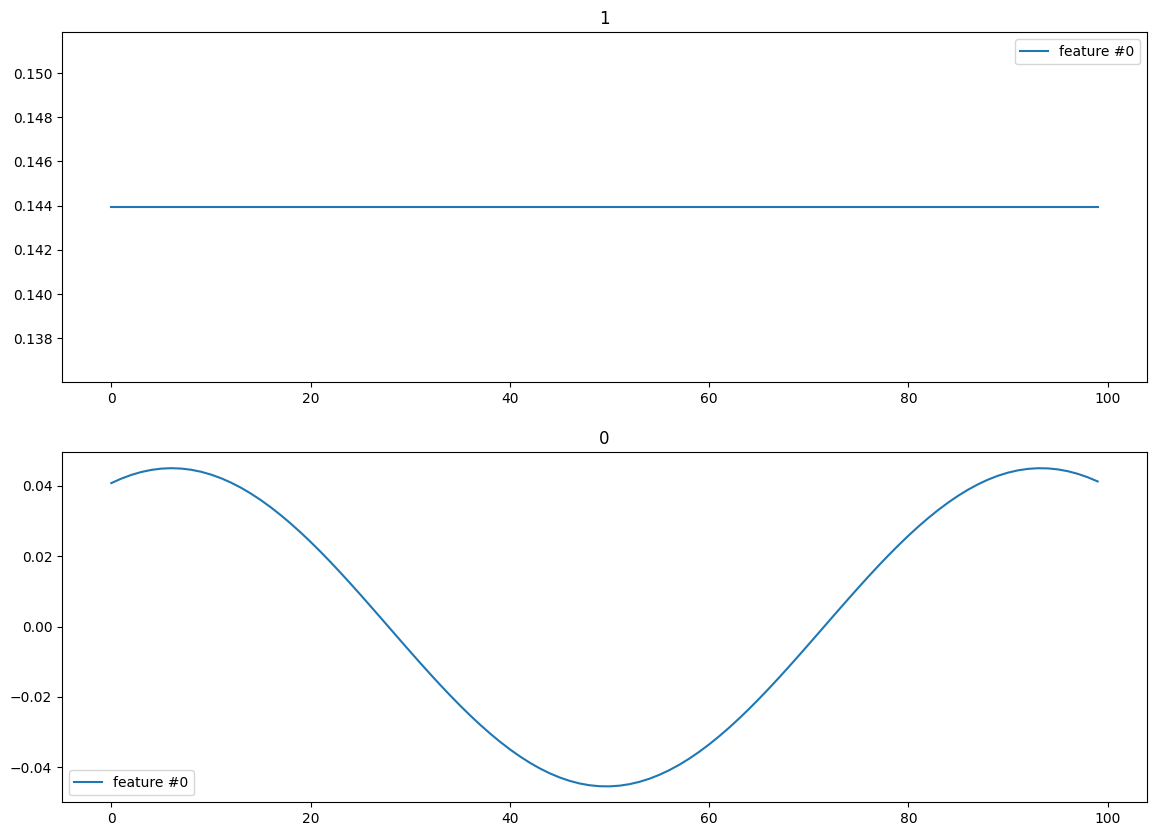

In [6]:
tsgm.utils.visualize_ts_lineplot(X_train, y_i, num=2)

In [7]:
architecture = tsgm.models.architectures.cGAN_LSTMnArchitecture(
    seq_len=seq_len, feat_dim=feature_dim,
    latent_dim=latent_dim, output_dim=output_dim)
discriminator, generator = architecture._discriminator, architecture._generator

In [9]:
architecture._discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 64)           17408     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________

In [10]:
architecture._generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 66)]              0         
                                                                 
 dense_1 (Dense)             (None, 6400)              428800    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6400)              0         
                                                                 
 reshape (Reshape)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 256)          328704    
                                                                 
 average_pooling1d (AverageP  (None, 100, 256)         0         
 ooling1D)                                                       
                                                         

Epoch 1/2
40/40 [==============================] - ETA: 0s - g_loss: 0.7046 - d_loss: 0.6925

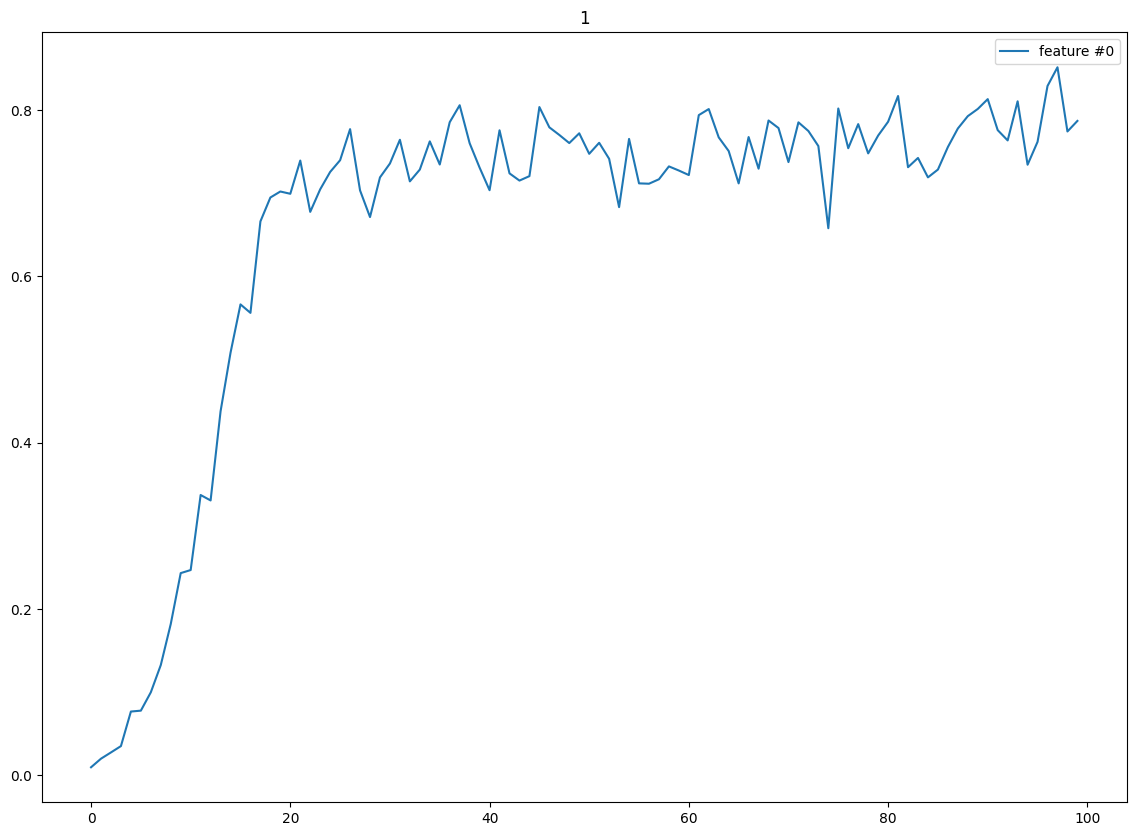

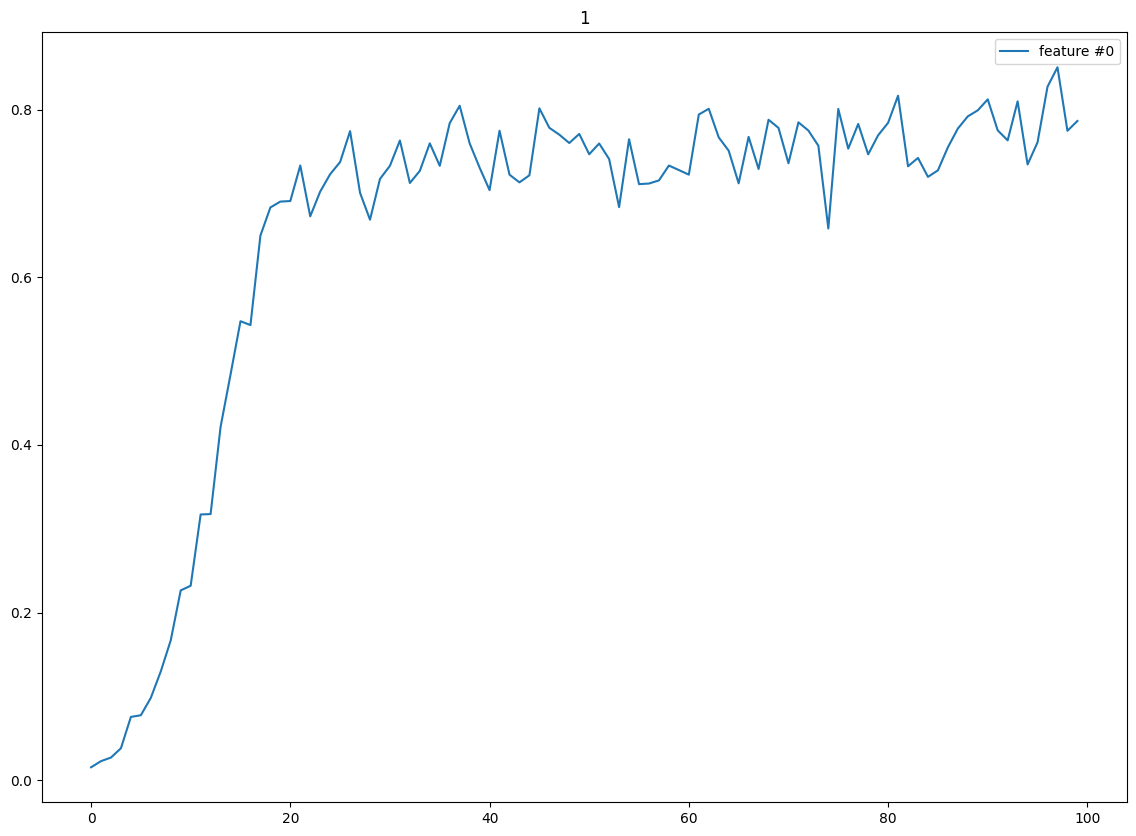

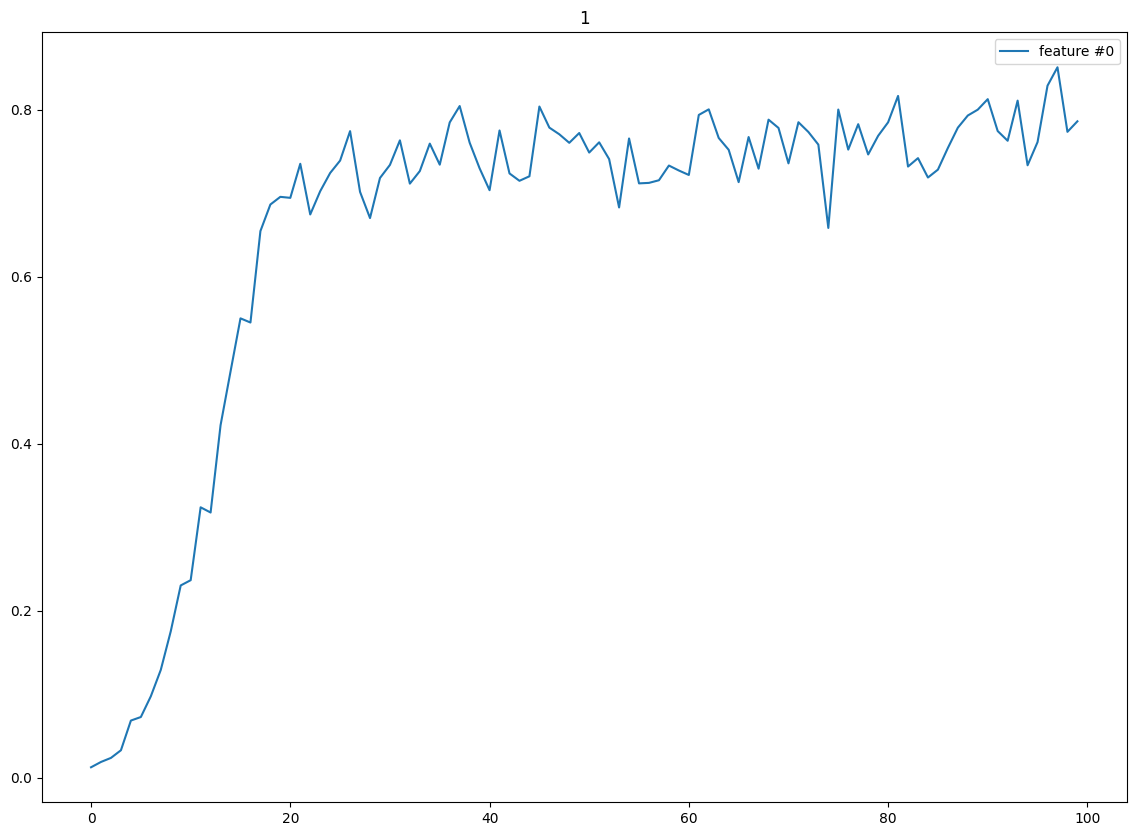

40/40 [==============================] - 255s 6s/step - g_loss: 0.7046 - d_loss: 0.6925
Epoch 2/2
40/40 [==============================] - ETA: 0s - g_loss: 0.7001 - d_loss: 0.6903

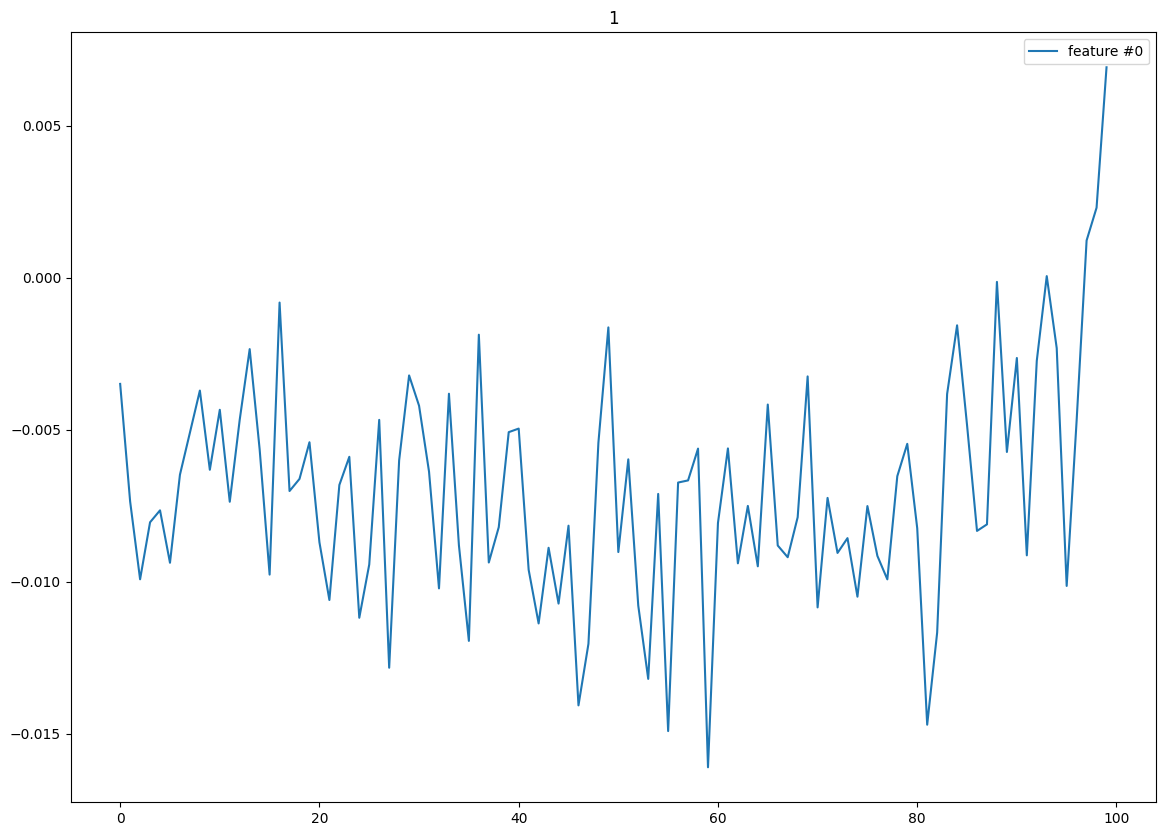

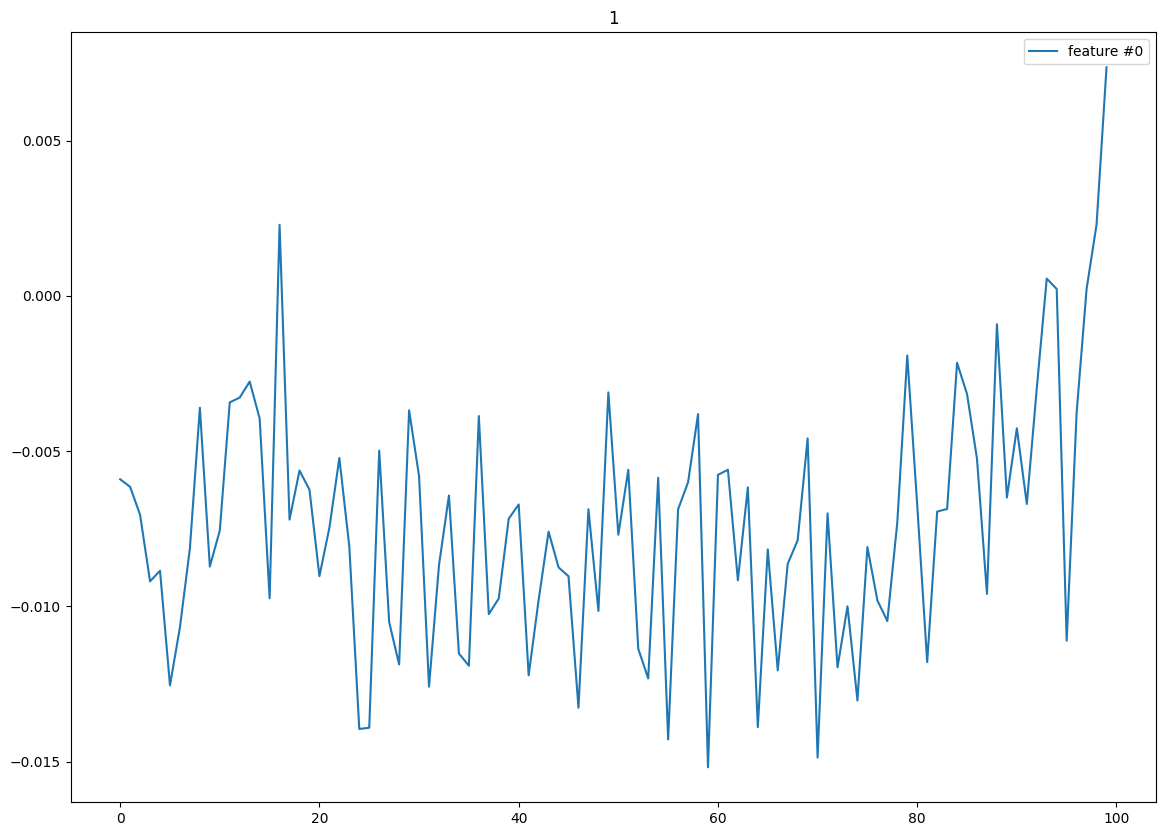

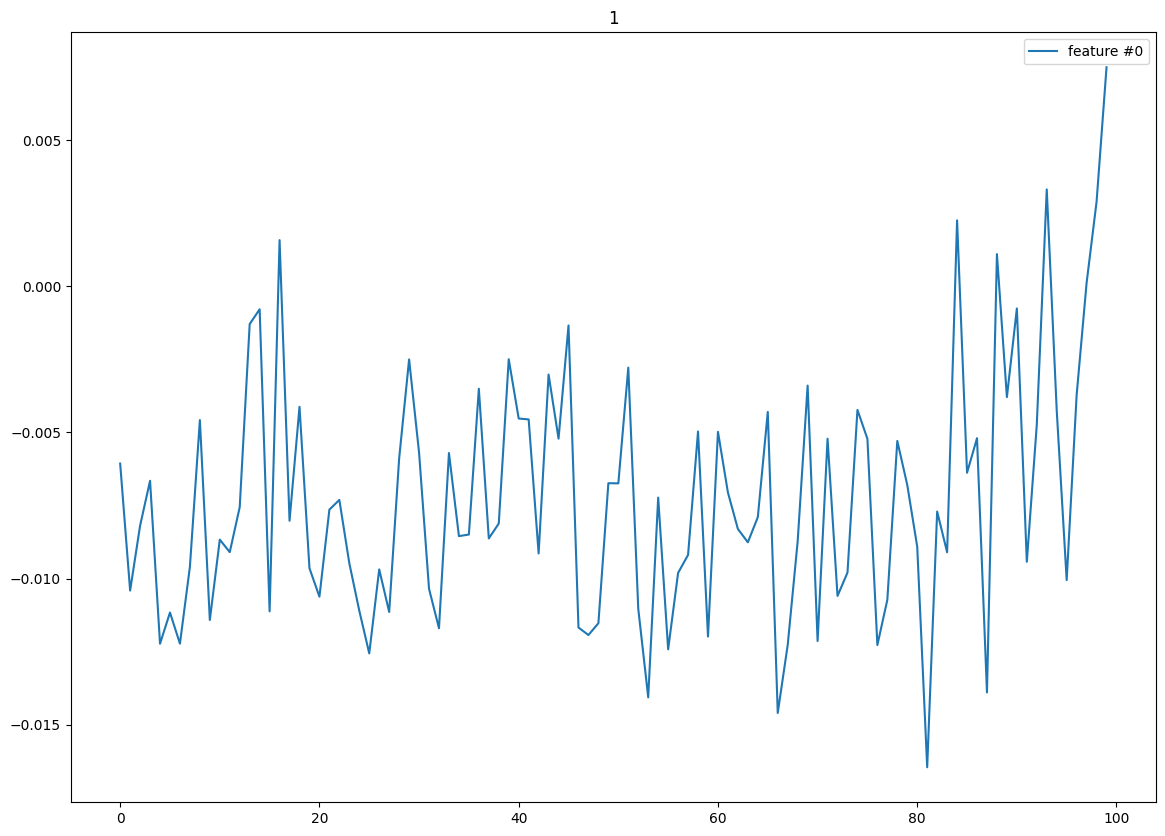

40/40 [==============================] - 237s 6s/step - g_loss: 0.6998 - d_loss: 0.6905


In [11]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=False, save_path="/tmp", labels=y)
cond_gan.fit(dataset, epochs=2, callbacks=[cbk])

In [13]:
X_gen = cond_gan.generate(y)

In [14]:
statistics = [functools.partial(tsgm.metrics.statistics.axis_max_s, axis=1),
              functools.partial(tsgm.metrics.statistics.axis_min_s, axis=1)]

sim_metric = tsgm.metrics.SimilarityMetric(
    statistics=statistics, discrepancy=lambda x, y: np.linalg.norm(x - y)
)

print(f"Similarity metric: {sim_metric(X, X_gen)}")

Similarity metric: 865.1385407992268


## Privacy preserving RCGAN

In [15]:
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 1
learning_rate = 0.01


d_optimizer = tf_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)


g_optimizer = tf_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

Epoch 1/2
40/40 [==============================] - ETA: 0s - g_loss: 0.7817 - d_loss: 0.6909

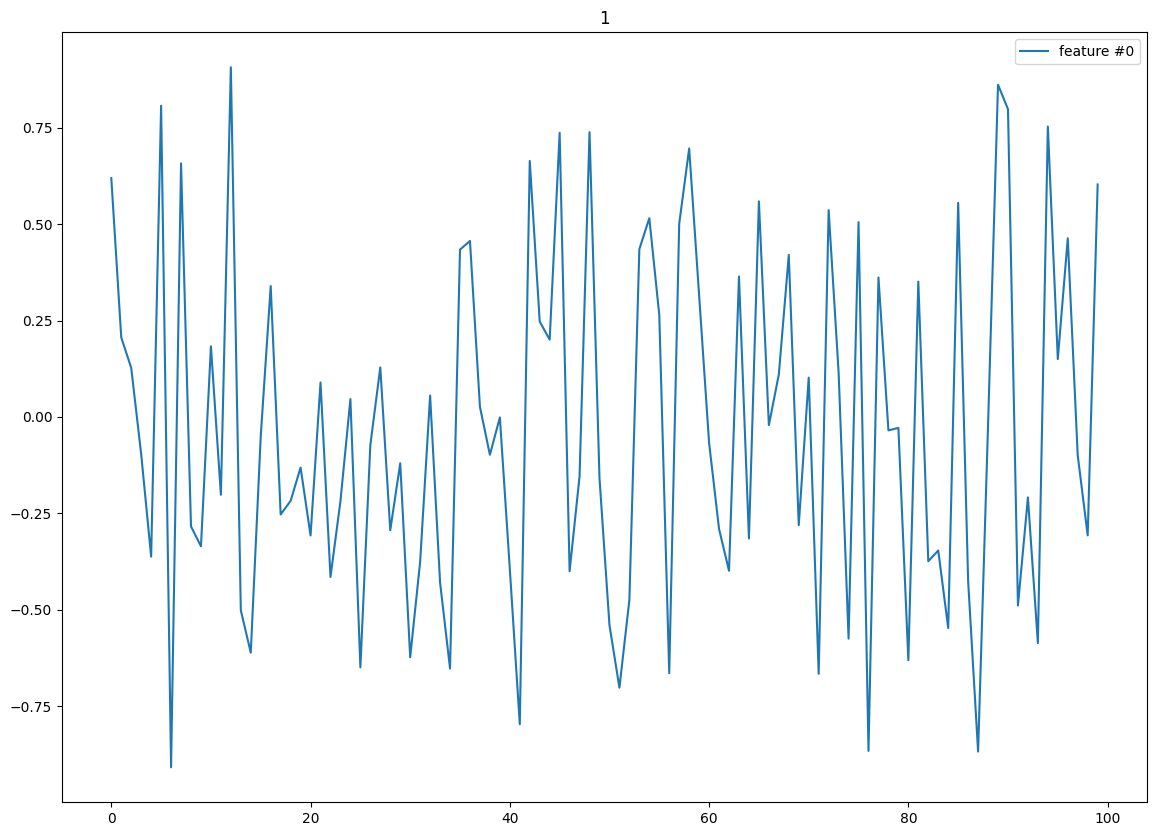

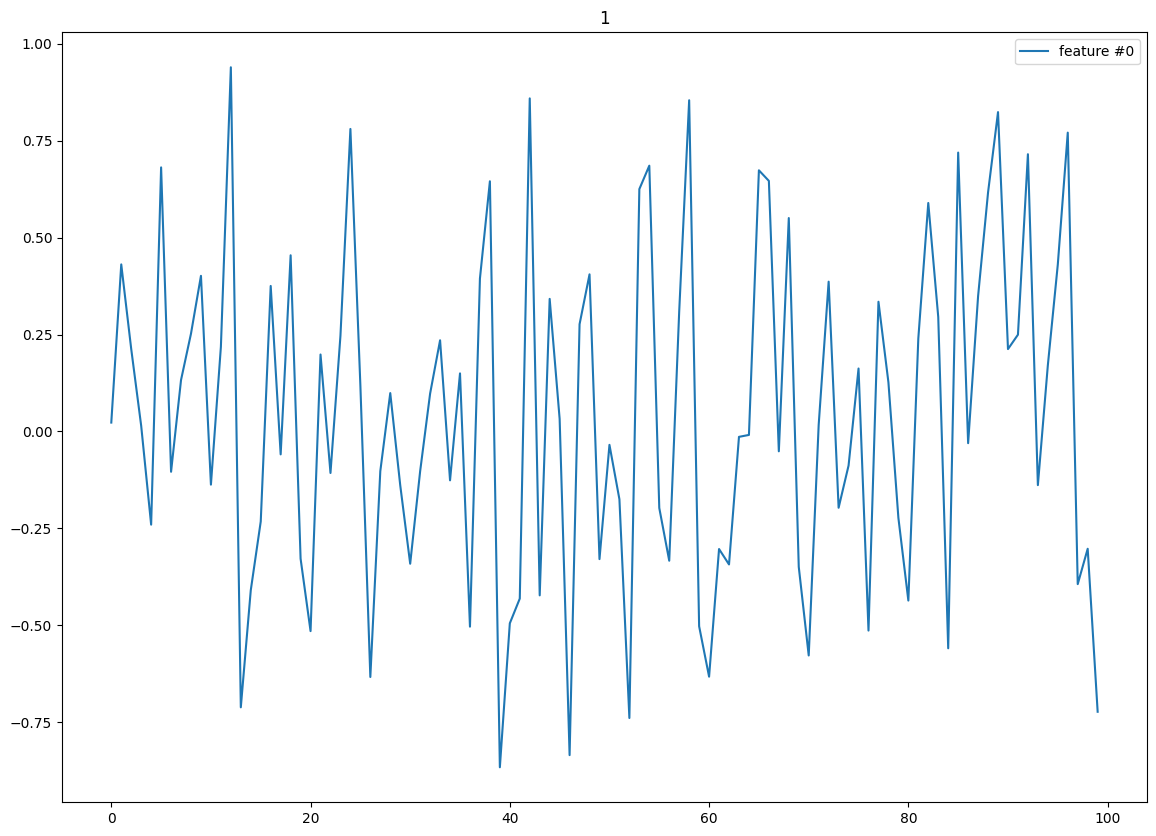

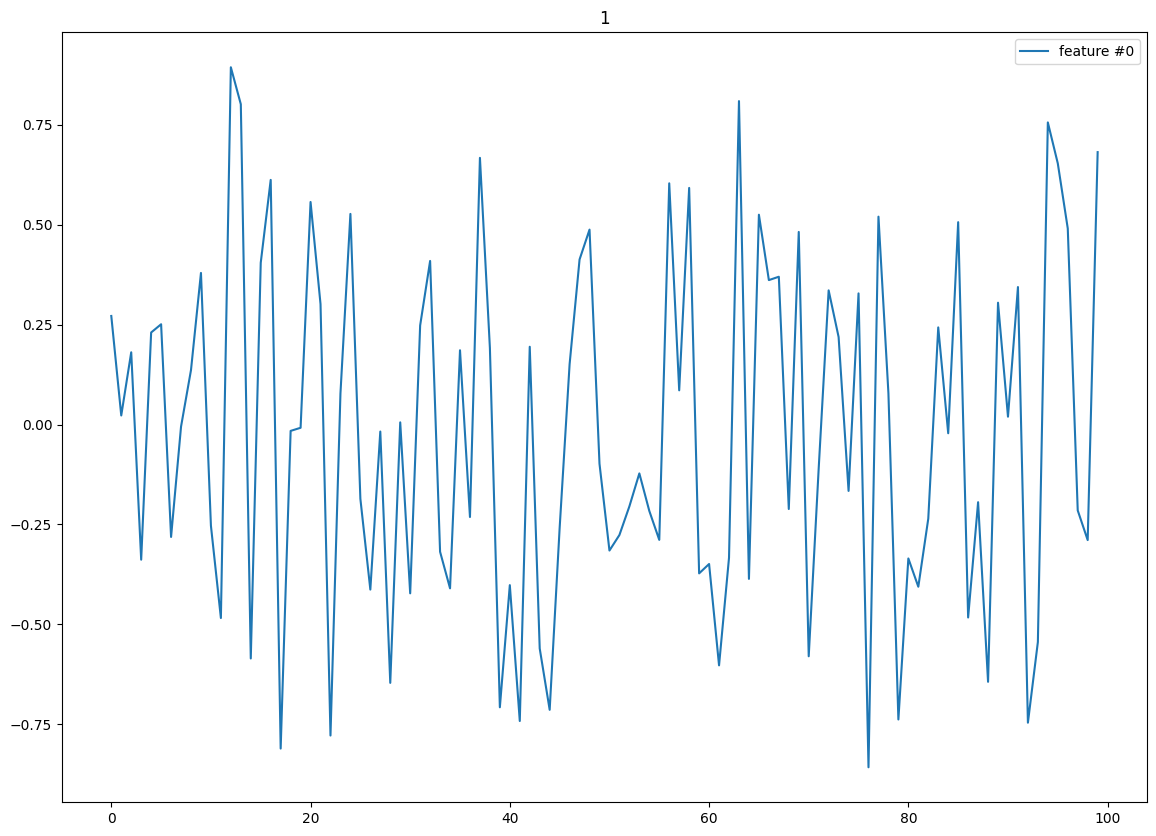

40/40 [==============================] - 353s 5s/step - g_loss: 0.7838 - d_loss: 0.6910
Epoch 2/2
40/40 [==============================] - ETA: 0s - g_loss: 0.8320 - d_loss: 0.7007

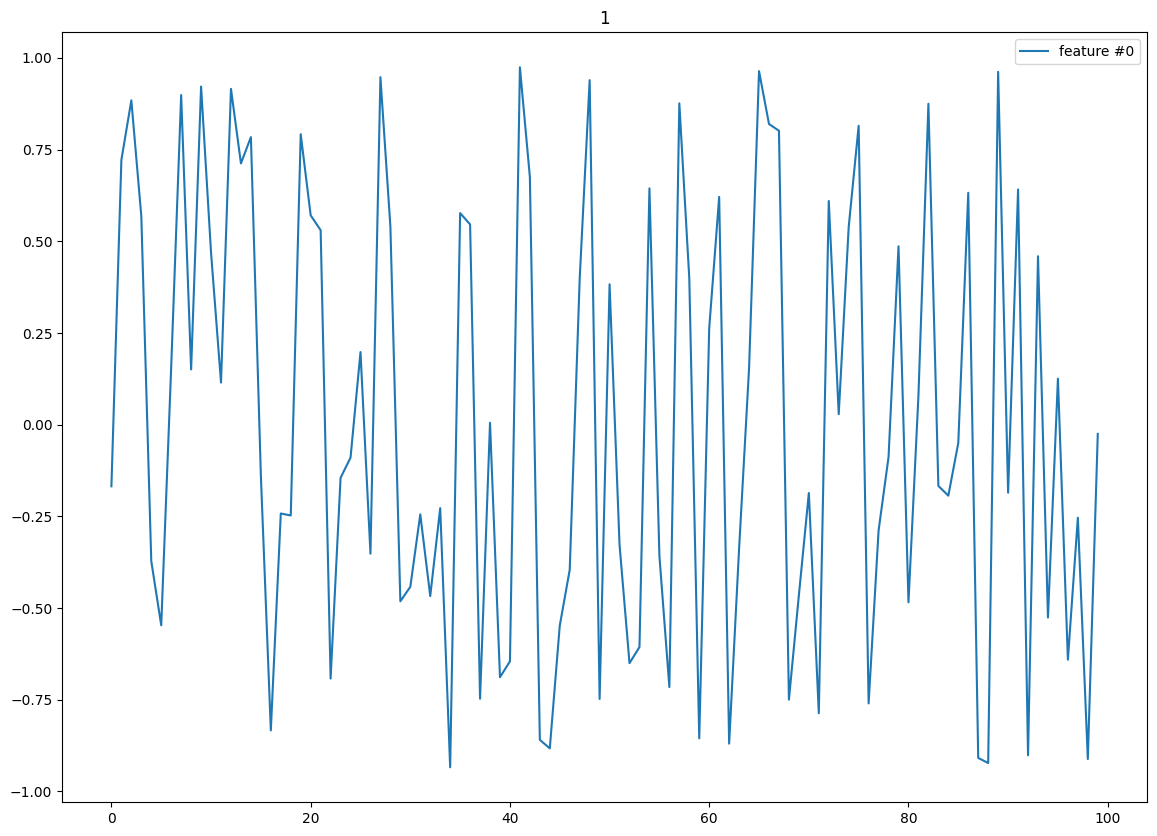

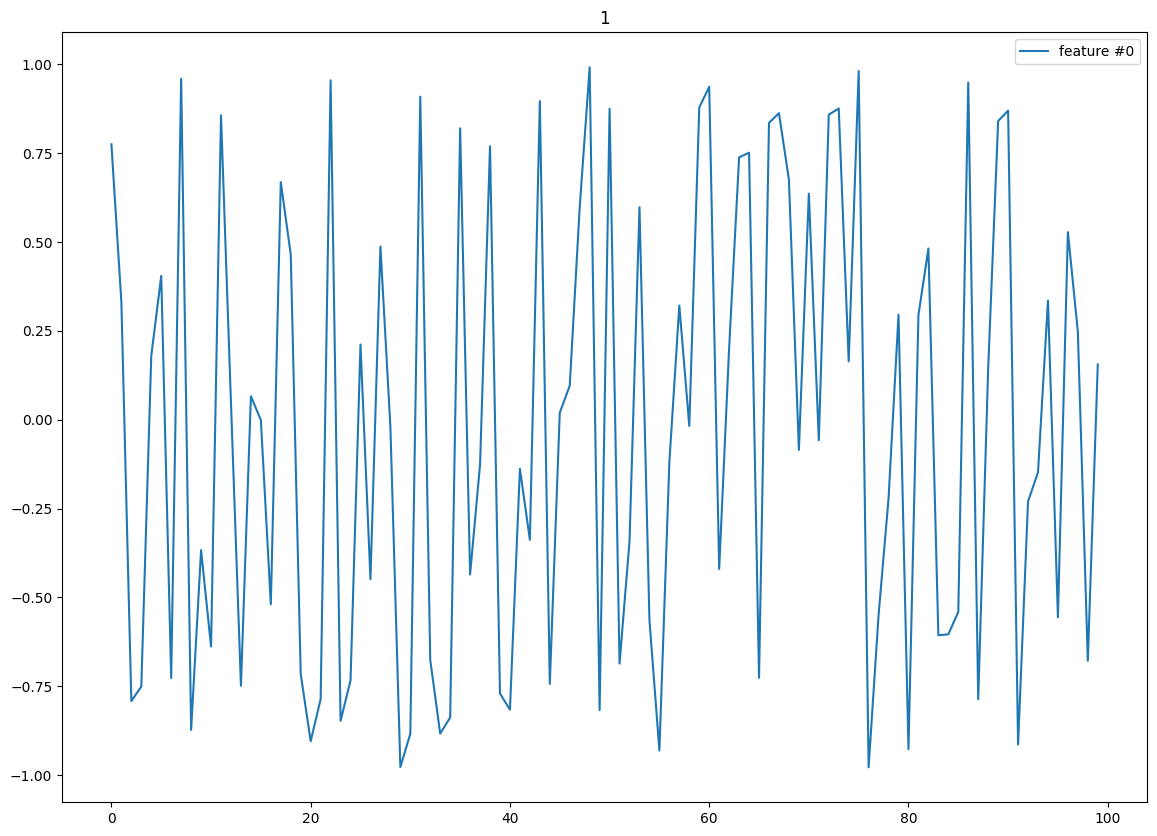

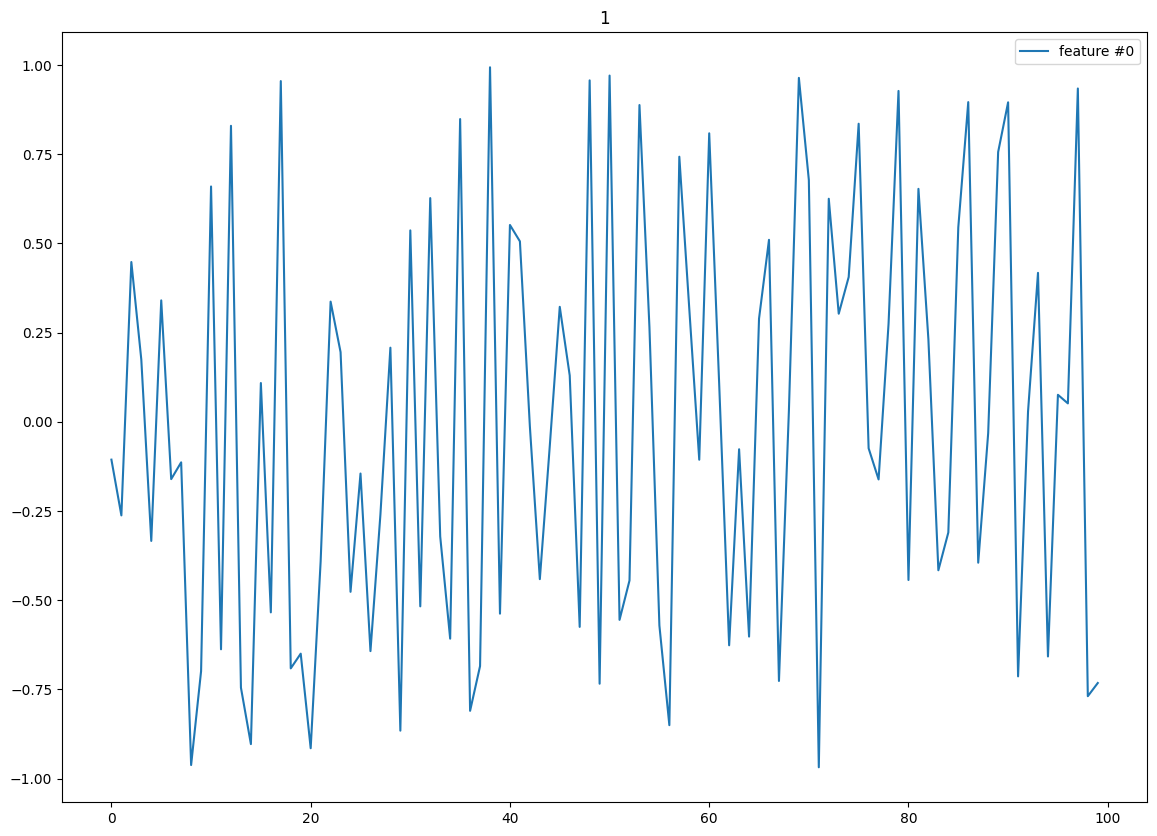

40/40 [==============================] - 190s 5s/step - g_loss: 0.8315 - d_loss: 0.7006


In [16]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=False, save_path="/tmp", labels=y)
cond_gan.fit(dataset, epochs=2, callbacks=[cbk])